In [16]:
import pandas as pd
import numpy as np
import yaml
from h3 import h3
from sklearn.cluster import DBSCAN
from sqlalchemy import create_engine
import psycopg2
import geopandas as gpd
from shapely.geometry import Polygon, LineString


import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
DB_USERNAME = 'sube_user'
DB_PASSWORD = 'sube_pass'
DB_HOST = 'localhost'
DB_PORT = '5432'
DB_NAME = 'sube'
DB_SCHEMA = 'public'

# Conectar a la db
conn = psycopg2.connect(user = DB_USERNAME,
                                      password = DB_PASSWORD,
                                      host = DB_HOST,
                                      port = DB_PORT,
                                      database = DB_NAME)

In [3]:
engine = create_engine('postgresql://{}:{}@{}:{}/{}'
    .format(DB_USERNAME, DB_PASSWORD, DB_HOST,
            DB_PORT, DB_NAME))

In [55]:
q = """
select *
from viajes_linea_b
"""
viajes = pd.read_sql(q, conn)

In [104]:
q = """
select *
from tramos_linea_b
"""
tramos = pd.read_sql(q, conn)

In [9]:
len(viajes)

426914

In [10]:
len(tramos)

713466

In [21]:
viajes.tramos.value_counts().sum()

426914

''

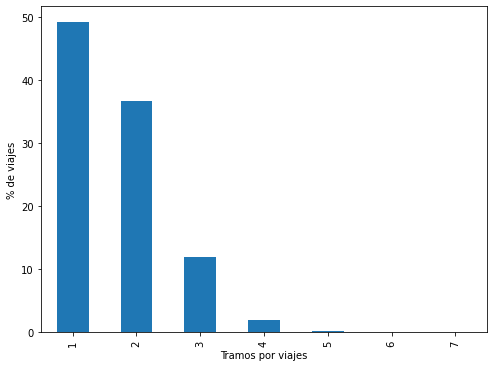

In [24]:
f,ax =plt.subplots(figsize = (8,6))
(viajes.tramos.value_counts()/len(viajes)*100).plot(kind='bar',ax=ax)
ax.set_xlabel('Tramos por viajes')
ax.set_ylabel('% de viajes')
;

In [56]:
tabla = viajes.reindex(columns = ['tarjeta','viaje_id','h3_o','h3_d'])
tabla = tabla.rename(columns = {'h3_o':'h3_o_11','h3_d':'h3_d_11'})
tabla = tabla.dropna(subset=['h3_d_11'])
tabla.head()

,tarjeta,viaje_id,h3_o_11,h3_d_11
0,32,0,8bc2e31094b1fff,8bc2e311c55efff
1,32,1,8bc2e311c55efff,8bc2e31094b1fff
2,36,0,8bc2e388925cfff,8bc2e311db95fff
3,36,1,8bc2e311da0cfff,8bc2e31094b1fff
5,42,0,8bc2e311c55efff,8bc2e311ec04fff


In [57]:
for res in range(5,11):
    tabla['h3_o_%s'%res] = tabla['h3_o_11']\
        .map(lambda h:h3.h3_to_parent(h,res=res))
    tabla['h3_d_%s'%res] = tabla['h3_d_11']\
        .map(lambda h:h3.h3_to_parent(h,res=res))

5
6
7
8
9
10


In [58]:
tabla.head()

,tarjeta,viaje_id,h3_o_11,h3_d_11,h3_o_5,h3_d_5,h3_o_6,h3_d_6,h3_o_7,h3_d_7,h3_o_8,h3_d_8,h3_o_9,h3_d_9,h3_o_10,h3_d_10
0,32,0,8bc2e31094b1fff,8bc2e311c55efff,85c2e313fffffff,85c2e313fffffff,86c2e310fffffff,86c2e311fffffff,87c2e3109ffffff,87c2e311cffffff,88c2e31095fffff,88c2e311c5fffff,89c2e31094bffff,89c2e311c57ffff,8ac2e31094b7fff,8ac2e311c55ffff
1,32,1,8bc2e311c55efff,8bc2e31094b1fff,85c2e313fffffff,85c2e313fffffff,86c2e311fffffff,86c2e310fffffff,87c2e311cffffff,87c2e3109ffffff,88c2e311c5fffff,88c2e31095fffff,89c2e311c57ffff,89c2e31094bffff,8ac2e311c55ffff,8ac2e31094b7fff
2,36,0,8bc2e388925cfff,8bc2e311db95fff,85c2e38bfffffff,85c2e313fffffff,86c2e388fffffff,86c2e311fffffff,87c2e3889ffffff,87c2e311dffffff,88c2e38893fffff,88c2e311dbfffff,89c2e388927ffff,89c2e311dbbffff,8ac2e388925ffff,8ac2e311db97fff
3,36,1,8bc2e311da0cfff,8bc2e31094b1fff,85c2e313fffffff,85c2e313fffffff,86c2e311fffffff,86c2e310fffffff,87c2e311dffffff,87c2e3109ffffff,88c2e311dbfffff,88c2e31095fffff,89c2e311da3ffff,89c2e31094bffff,8ac2e311da0ffff,8ac2e31094b7fff
5,42,0,8bc2e311c55efff,8bc2e311ec04fff,85c2e313fffffff,85c2e313fffffff,86c2e311fffffff,86c2e311fffffff,87c2e311cffffff,87c2e311effffff,88c2e311c5fffff,88c2e311edfffff,89c2e311c57ffff,89c2e311ec3ffff,8ac2e311c55ffff,8ac2e311ec07fff


In [60]:
resolucion_grande = 5
resolucion_chica = 11
tipo = 'viajes'

In [71]:
for resolucion in range(resolucion_grande,resolucion_chica+1):
    #crear tabla con OD por hexagrilla
    par_OD_resolucion = ['h3_o_%s'%(resolucion),'h3_d_%s'%(resolucion)]
    tabla_OD = tabla.reindex(columns = par_OD_resolucion).groupby(par_OD_resolucion).size().reset_index()
    tabla_OD.columns = par_OD_resolucion +['n']
    tabla_OD[par_OD_resolucion[1]].replace({'0':'Desconocido'},inplace=True) 
    tabla_OD.to_csv('../tablas/tabla_%s_OD_res_%s.csv'%(tipo,resolucion),index=False)


    # cartografia de todas las hexagrillas de una resolucion dada
    lista_indices_global = pd.concat([pd.Series(tabla['h3_o_%s'%(resolucion)].unique()),
                                      pd.Series(tabla['h3_d_%s'%(resolucion)].unique())]).unique()
    
    # indice para los None
    lista_indices_global = lista_indices_global[lista_indices_global!='0']
    geo_df = gpd.GeoDataFrame(lista_indices_global, geometry = [Polygon(h3.h3_to_geo_boundary(h3_address=h,geo_json=True)) \
                                          for h in lista_indices_global],\
                              crs = 'EPSG:4326')
    geo_df.columns=['h3_index','geometry']
    geo_df.to_file('../carto/carto_hex_res_%s.geojson'%(resolucion),driver='GeoJSON')
    
    #crear cartografia de recorridos para una resolucion dada
    
    geometria = [LineString([h3.h3_to_geo(tabla_OD.loc[i][par_OD_resolucion[0]])[::-1],
            h3.h3_to_geo(tabla_OD.loc[i][par_OD_resolucion[1]])[::-1]
                            ]
                           ) for i in tabla_OD.index]    
    geo_df = gpd.GeoDataFrame(tabla_OD, geometry = geometria,crs = 'EPSG:4326')
    geo_df.to_file('../carto/recorridos_%s_res_%s.geojson'%(tipo,resolucion),driver='GeoJSON')


In [105]:
tramos.head()

,tarjeta,tramo_id,linea,fecha,lat_o,lon_o,delta,h3_o,lat_d,lon_d,h3_d,viaje_id
0,2996396,4,LINEA 132,2018-10-10 19:35:37,-34.598050,-58.370530,NaN,8bc2e31adc1efff,None,None,8bc2e31add5dfff,2
1,2997539,0,LINEA B,2018-10-10 08:30:46,-34.602162,-58.431274,1.594000e+13,8bc2e311ca68fff,None,None,8bc2e31aca6efff,0
2,2997900,0,LINEA 42,2018-10-10 14:23:43,-34.573940,-58.447400,9.050000e+11,8bc2e3119a72fff,None,None,8bc2e310ad42fff,0
3,2997900,2,SUBTE,2018-10-10 15:17:42,-34.604581,-58.405399,1.687000e+12,8bc2e311e96bfff,None,None,8bc2e310ad46fff,0
4,2997906,1,LINEA 7,2018-10-10 10:03:33,-34.585950,-58.370220,9.084000e+12,8bc2e31ad691fff,None,None,8bc2e3113696fff,0


In [107]:
tramos['urquiza'] = (tramos.linea == 'METROVIAS S.A. (URQUIZA)').map(int)
tramos['mitre'] = (tramos.linea == 'SOFSE - Mitre').map(int)


In [108]:
urquiza = tramos.reindex(columns=['tarjeta','tramo_id','urquiza']).groupby(['tarjeta','tramo_id']).sum()
mitre = tramos.reindex(columns=['tarjeta','tramo_id','mitre']).groupby(['tarjeta','tramo_id']).sum()

In [119]:
urquiza.urquiza.sum() / len(urquiza) * 100

6.127832300347879

In [120]:
mitre.mitre.sum() / len(urquiza) * 100

2.3716617189887117

In [110]:
tramos = tramos.dropna(subset=['h3_d'])

tramos['h3_o_8'] = tramos['h3_o']\
        .map(lambda h:h3.h3_to_parent(h,res=8))
tramos['h3_d_8'] = tramos['h3_d']\
        .map(lambda h:h3.h3_to_parent(h,res=8))

In [ ]:
# CELDA LACROZE 88c2e310adfffff

In [129]:
tramos_celda_urquiza = tramos.loc[(tramos.h3_o_8 == '88c2e31095fffff') |(tramos.h3_d_8 == '88c2e31095fffff'),:]
urquiza_celda = tramos_celda_urquiza.reindex(columns=['tarjeta','tramo_id','mitre']).groupby(['tarjeta','tramo_id']).sum()


In [131]:
urquiza_celda.mitre.sum() / len(urquiza_celda) * 100

13.152043783136651

In [125]:
tramos_celda_urquiza.mitre.sum() / len(tramos_celda_urquiza) * 100

13.152043783136651

In [122]:
tramos_celda_lacroze = tramos.loc[(tramos.h3_o_8 == '88c2e310adfffff') | (tramos.h3_d_8 == '88c2e310adfffff'),:]


In [124]:
tramos_celda_lacroze.urquiza.sum() / len(tramos_celda_lacroze) * 100

31.146929951710828

In [121]:
tramos_celda_lacroze_loop = tramos.loc[(tramos.h3_o_8 == '88c2e310adfffff') & (tramos.h3_d_8 == '88c2e310adfffff'),:]
tramos_celda_lacroze_loop

,tarjeta,tramo_id,linea,fecha,lat_o,lon_o,delta,h3_o,lat_d,lon_d,h3_d,viaje_id,urquiza,mitre,h3_o_8,h3_d_8
281,3191636,3,LINEA 39,2018-10-10 20:57:16,-34.587710,-58.452590,NaN,8bc2e310ad19fff,None,None,8bc2e310ad46fff,2,0,0,88c2e310adfffff,88c2e310adfffff
355,3242717,1,METROVIAS S.A. (URQUIZA),2018-10-10 17:26:24,-34.585117,-58.455304,NaN,8bc2e310ac44fff,None,None,8bc2e310ad41fff,1,1,0,88c2e310adfffff,88c2e310adfffff
383,3264706,2,METROVIAS S.A. (URQUIZA),2018-10-10 19:54:38,-34.585117,-58.455304,NaN,8bc2e310ac44fff,None,None,8bc2e310ad41fff,1,1,0,88c2e310adfffff,88c2e310adfffff
708,3582738,8,LINEA 47,2018-10-10 16:28:56,-34.587440,-58.454150,2.990000e+11,8bc2e310ad54fff,None,None,8bc2e310ad56fff,3,0,0,88c2e310adfffff,88c2e310adfffff
776,3653093,1,LINEA 123,2018-10-10 21:37:14,-34.586730,-58.456870,NaN,8bc2e310ad6bfff,None,None,8bc2e310ad72fff,1,0,0,88c2e310adfffff,88c2e310adfffff
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
712565,11104546,1,LINEA B,2018-10-10 08:01:08,-34.587198,-58.455029,3.964100e+13,8bc2e310ad46fff,None,None,8bc2e310ad46fff,0,0,0,88c2e310adfffff,88c2e310adfffff
712857,11226361,0,LINEA B,2018-10-10 12:50:29,-34.587198,-58.455029,1.284600e+13,8bc2e310ad46fff,None,None,8bc2e310ad46fff,0,0,0,88c2e310adfffff,88c2e310adfffff
712973,11090707,0,LINEA B,2018-10-10 12:48:43,-34.587198,-58.455029,1.210400e+13,8bc2e310ad46fff,None,None,8bc2e310ad46fff,0,0,0,88c2e310adfffff,88c2e310adfffff
713319,11226477,2,METROVIAS S.A. (URQUIZA),2018-10-10 16:42:02,-34.585117,-58.455304,NaN,8bc2e310ac44fff,None,None,8bc2e310ad41fff,1,1,0,88c2e310adfffff,88c2e310adfffff
